# FRQI – Guía de Uso Rápido (Notebook)

- Propósito
  - Validar el modelo (fórmula FRQI) vs circuito propuesto y el statevector producido.
  - Validar muestreo (√p) vs statevector.
  - Reconstrucción de las imágenes y métricas opcionales.

- Orden recomendado
  1) Teórico (fórmula) vs Circuito (statevector)
  2) Circuito (statevector) vs Muestreo (√p)
  3) (Opcional) Reconstrucción y métricas

- Dispositivos
  - `lightning.qubit`: simulador por statevector (preciso/rápido) → “Circuito (statevector)”
  - `default.qubit`: simulador con `shots>0` (tipo hardware) → “Muestreo (√p)”

- Canales de color
  - Con `n_color_qubits = C`, hay `2^C` canales.
  - Pasa una lista de `C` imágenes en orden: [MSB → LSB], p. ej. dos canales: `[img0, img1]`.
  - Si usas una sola imagen, se replica en todos los canales.

- Parámetros sugeridos
  - `image_size` = potencia de 2 (4, 8, 16, …)
  - `device_exact = "lightning.qubit"`
  - `device_sampling = "default.qubit"`
  - `shots = 8192` o `16384` para reducir error ~ 1/√shots
  - `threshold_exact = 1e-6`, `threshold_samp = 1e-3`

- Imports y modelo (ejemplo)
  - `from src import FRQI, FRQI2, FRQI3, generate_image, select_frqi`
  - `Model = select_frqi(n_color_qubits); model = Model(image_size, device=device_exact)`

- Lectura de resultados
  - “Teórico (fórmula)” ≈ “Circuito (statevector)” → valida la implementación del encode.
  - “Circuito (statevector)” ≈ “Muestreo (√p)” → valida el conteo estadístico (diferencias ↓ con más shots).


In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

project_root = os.path.dirname(os.getcwd()) if "notebooks" in os.getcwd() else os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"📂 Proyecto cargado desde: {project_root}")

from src import FRQI, FRQI2, FRQI3, generate_image, select_frqi

📂 Proyecto cargado desde: c:\Users\ometi\Documents\IA\Github\FRQI project


# FRQI: Modelo y Flujo de Codificación

## 1. Representación de Imágenes

Las posibilidades de codificacion de imágenes en computación cuántica son variadas con modelos que aprovechan tanto las amplitudes, fases o estados base de una funcion de onda cuántica para codificar la información. Aquí nos centramos en el modelo **FRQI** (Flexible Representation of Quantum Images), que permite una expansion para manejar múltiples canales usando los correspondientes qubits en los cuales podemos anexar informacion de color o otras imágenes en escala de grises por ejemplo.
El modelo original **FRQI** representa una imagen de $P$ píxeles mediante una superposición cuántica de estados donde:

- Las **posiciones** de los píxeles se codifican en los estados base
- Las **intensidades de color** se codifican en las amplitudes mediante ángulos de rotación

## Configuración de Qubits

$$
n_{\text{qubits}} = n_{\text{pos}} + n_{\text{color}}
$$

donde:
- $n_{\text{pos}} = \lceil \log_2(P) \rceil$ : número de qubits para codificar posiciones
- $n_{\text{color}} \in \{1, 2, 3\}$ : número de qubits para codificar canales.

**Ejemplo:** Para una imagen de 8×8 píxeles (P=64) con escala de grises:
- $n_{\text{pos}} = 6$ qubits
- $n_{\text{color}} = 1$ qubit
- Total: 7 qubits

---
### Orden Big-Endian

Adoptamos la convención **big-endian** donde el wire 0 representa el bit más significativo (MSB):

In [2]:
# Configuración
image_size = 4
n_color_qubits = 2  # 1 | 2 | 3

device_exact = "lightning.qubit"
device_sampling = "default.qubit"
shots = 8192

threshold_exact = 1e-6
threshold_samp = 1e-3

# Validación
assert (image_size & (image_size - 1)) == 0, "image_size debe ser potencia de 2 (4, 8, 16, ...)"

# Construir modelo
Model = select_frqi(n_color_qubits)
model = Model(image_size, device=device_exact)
print(f"Modelo: {Model.__name__} | Qubits color: {n_color_qubits} | Dispositivo exacto: {device_exact}")


Modelo: FRQI2 | Qubits color: 2 | Dispositivo exacto: lightning.qubit


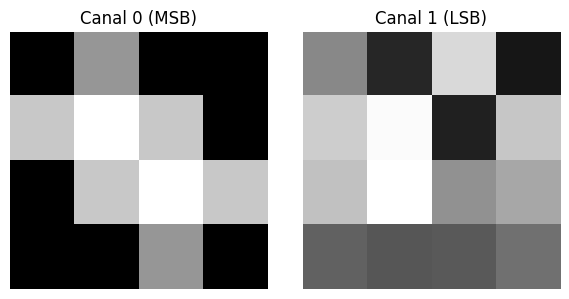

In [3]:
# Dos patrones distintos por canal
img0 = generate_image(image_size=image_size, use_pattern=True)
img1 = generate_image(image_size=image_size, use_pattern=False, seed=42)
images = [img0, img1]   # orden: canal MSB, canal LSB

# Visualización rápida
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].imshow(img0, cmap="gray", vmin=0, vmax=255); axs[0].set_title("Canal 0 (MSB)"); axs[0].axis("off")
axs[1].imshow(img1, cmap="gray", vmin=0, vmax=255); axs[1].set_title("Canal 1 (LSB)"); axs[1].axis("off")
plt.tight_layout(); plt.show()


### Desglose de Wires

| Rango de Wires | Función | Descripción |
|----------------|---------|-------------|
| `0 ... n_pos-1` | Posición | Codifican la ubicación del píxel (MSB → LSB) |
| `n_pos ... n_qubits-1` | Color | Codifican la intensidad/canal de color (MSB → LSB) |

### Mapeo de Índice Base (detalle pero importante)

El índice del estado base se calcula como:

$$
\text{idx} = (\text{pos\_idx} \ll n_{\text{color}}) \,|\, \text{color\_bits}
$$

donde:
- `pos_idx`: índice de posición del píxel
- `color_bits`: bits del color en formato binario (MSB → LSB)
- `<<` : operador de desplazamiento a la izquierda (shift left)
- `|` : operador OR bit a bit

**Ejemplo:** Para `n_color = 1`, píxel en posición 3, color claro (bit=0):
$$
\text{idx} = (3 \ll 1) | 0 = 6 + 0 = 6 \quad \rightarrow \quad |110\rangle
$$

---

## 3. Ángulos y Normalización

### Codificación de Intensidad

Para cada canal $k$ y píxel en posición $i$, el ángulo de rotación se define como:

$$
\theta_k(i) = \frac{\pi}{2} \cdot \frac{I_k(i)}{255}
$$

donde:
- $I_k(i) \in [0, 255]$ es la intensidad del píxel en el canal $k$
- $\theta_k(i) \in [0, \pi/2]$ es el ángulo de rotación correspondiente

### Normalización por Superposición

La amplitud base se normaliza por la superposición uniforme de posiciones:

$$
\text{Amplitud base} = \frac{1}{\sqrt{P}}
$$

Esta normalización garantiza que la suma de las probabilidades de todos los estados sea 1.

---

## 4. Fórmula de Amplitudes

### Expresión General

La amplitud para un estado cuántico $|\text{pos}\rangle \otimes |\text{color\_bits}\rangle$ se calcula como:

$$
\alpha(\text{pos}, \text{color\_bits}) = \frac{1}{\sqrt{P}} \cdot \prod_{k=0}^{n_{\text{color}}-1} f_k(i)
$$

donde la función $f_k(i)$ se define según el bit $k$ del color:

$$
f_k(i) = \begin{cases}
\cos(\theta_k(i)) & \text{si el bit } k \text{ del color es } 0 \\
\sin(\theta_k(i)) & \text{si el bit } k \text{ del color es } 1
\end{cases}
$$

### Interpretación

- **Bit 0 (píxel oscuro)**: Usa $\cos(\theta)$ → valores bajos de intensidad dan amplitudes altas
- **Bit 1 (píxel claro)**: Usa $\sin(\theta)$ → valores altos de intensidad dan amplitudes altas

### Propiedad de Positividad

Dado que $\theta_k \in [0, \pi/2]$:

$$
\cos(\theta_k) \geq 0 \quad \text{y} \quad \sin(\theta_k) \geq 0
$$

Por lo tanto:

$$
\alpha(\text{pos}, \text{color\_bits}) \in \mathbb{R}^+ \quad \text{(coeficientes reales y no negativos)}
$$

**Implicación:** Todas las amplitudes en FRQI son reales y no negativas, lo que simplifica el análisis del estado cuántico.

---

## 5. Estado Cuántico Completo

El estado FRQI completo de una imagen se puede escribir como:

$$
|\psi\rangle = \frac{1}{\sqrt{P}} \sum_{i=0}^{P-1} \sum_{c=0}^{2^{n_{\text{color}}}-1} \alpha(i, c) \, |i\rangle \otimes |c\rangle
$$

donde:
- $|i\rangle$ representa la posición del píxel
- $|c\rangle$ representa el color/intensidad
- $\alpha(i, c)$ es la amplitud calculada según la fórmula anterior

### Normalización Total

El estado satisface la condición de normalización:

$$
\langle\psi|\psi\rangle = \sum_{i=0}^{P-1} \sum_{c=0}^{2^{n_{\text{color}}}-1} |\alpha(i, c)|^2 = 1
$$


# Proceso de Codificación FRQI (Circuito Cuántico)

## 1. Pasos del Circuito

### Paso 1: Inicialización
Inicializamos todos los qubits en el estado fundamental:

$$
|\psi_0\rangle = |0\rangle^{\otimes n_{\text{qubits}}} = |\underbrace{00\ldots0}_{\text{posición}}\rangle \otimes |\underbrace{00\ldots0}_{\text{color}}\rangle
$$

### Paso 2: Superposición de Posiciones
Aplicamos compuertas Hadamard a todos los qubits de posición:

$$
H^{\otimes n_{\text{pos}}} : |\psi_0\rangle \rightarrow |\psi_1\rangle = \frac{1}{\sqrt{P}} \sum_{i=0}^{P-1} |i\rangle \otimes |00\ldots0\rangle
$$

**Efecto:** Creamos una superposición uniforme sobre todas las posiciones de píxeles posibles.

### Paso 3: Codificación de Intensidades
Para cada píxel $i$ (de 0 a P-1):

**a) Selección de posición:**
   - Configuramos los qubits de posición para apuntar a $|i\rangle$
   - Usamos compuertas X controladas según la representación binaria de $i$ (MSB → LSB)

**b) Codificación de color:**
   - Para cada canal de color $k$:
     - Aplicamos una rotación RY controlada al qubit de color $k$:
     
$$
C^{n_{\text{pos}}}RY(2\theta_k(i)) : \text{qubit}_{n_{\text{pos}}+k}
$$

   - Control: todos los qubits de posición deben estar en el estado $|i\rangle$
   - Ángulo: $2\theta_k(i) = \pi \cdot \frac{I_k(i)}{255}$

### Diagrama del Circuito (ejemplo 2×2, 1 color)

**Efecto:** Creamos una superposición uniforme sobre todas las posiciones de píxeles posibles.
```python
# Pseudocódigo
for wire in range(n_pos):
    qml.Hadamard(wires=wire)
```
### Paso 3: Codificación de Intensidades
Para cada píxel $i$ (de 0 a P-1):

**a) Selección de posición:**
   - Configuramos los qubits de posición para apuntar a $|i\rangle$
   - Usamos compuertas X controladas según la representación binaria de $i$ (MSB → LSB)

**b) Codificación de color:**
   - Para cada canal de color $k$:
     - Aplicamos una rotación RY controlada al qubit de color $k$:
     
$$
C^{n_{\text{pos}}}RY(2\theta_k(i)) : \text{qubit}_{n_{\text{pos}}+k}
$$

   - Control: todos los qubits de posición deben estar en el estado $|i\rangle$
   - Ángulo: $2\theta_k(i) = \pi \cdot \frac{I_k(i)}{255}$


### Paso 4: Estado Final
Después de codificar todos los píxeles, obtenemos el estado FRQI completo:

$$
|\psi_{\text{final}}\rangle = \frac{1}{\sqrt{P}} \sum_{i=0}^{P-1} \sum_{c=0}^{2^{n_{\text{color}}}-1} \alpha(i, c) \, |i\rangle \otimes |c\rangle
$$


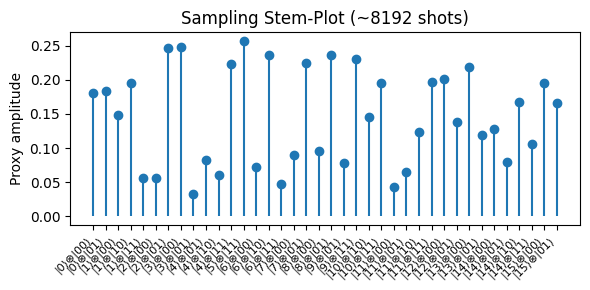

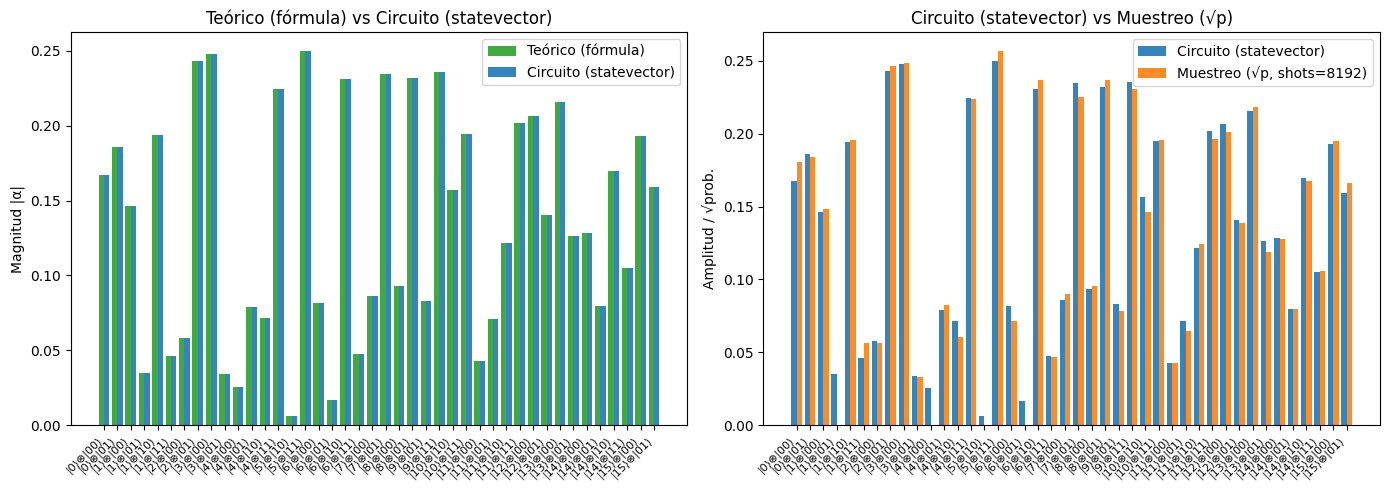

Resumen:
  Panel A (Teórico vs Circuito): max |Δ|=8.327e-17, mean |Δ|=4.630e-17
  Panel B (Circuito vs Muestreo): max |Δ|=3.494e-02, mean |Δ|=5.835e-03


In [8]:
# Dos paneles: (A) Teórico (fórmula) vs Circuito (statevector)
#              (B) Circuito (statevector) vs Muestreo (√p)

import numpy as np
import matplotlib.pyplot as plt

# Asegura que 'images' coincide con el nº de qubits de color
if isinstance(images, np.ndarray):
    images = [images] * model.n_color_qubits
elif len(images) != model.n_color_qubits:
    images = [images[0]] * model.n_color_qubits

# Estados: teórico (fórmula) y del circuito (statevector)
state_theo = model.theoretical_state(*images)
state_code = model.encode(*images)
amps_theo = np.abs(state_theo)
amps_code = np.abs(state_code)

# Muestreo usando el método del módulo (cerramos la figura que crea)
nz_samp, vals_samp = model.stem_plot_amplitudes(
    images, shots=shots, device=device_sampling, threshold=threshold_samp, figsize=(6,3)
)
plt.close()

def label(idx, n_color):
    pos = idx >> n_color
    col = format(idx & ((1 << n_color) - 1), f"0{n_color}b")
    return f"|{pos}⟩⊗|{col}⟩"

# Panel A: indices relevantes por umbral en teórico o circuito
idx_A = sorted(set(np.nonzero(amps_theo > threshold_exact)[0]) |
               set(np.nonzero(amps_code > threshold_exact)[0]))
if len(idx_A) == 0:
    K = min(32, len(amps_code))
    idx_A = list(np.argsort(amps_code)[-K:][::-1])

vt = np.array([amps_theo[i] for i in idx_A])  # Teórico |α|
vc = np.array([amps_code[i] for i in idx_A])  # Circuito |α|
labels_A = [label(i, model.n_color_qubits) for i in idx_A]
xA = np.arange(len(idx_A))

# Panel B: unir indices de muestreo y de circuito sobre umbral
idx_B = sorted(set(int(i) for i in nz_samp) |
               set(np.nonzero(amps_code > threshold_exact)[0]))
if len(idx_B) == 0:
    K = min(32, len(amps_code))
    idx_B = list(np.argsort(amps_code)[-K:][::-1])

d_samp = {int(i): float(v) for i, v in zip(nz_samp, vals_samp)}
vs = np.array([d_samp.get(int(i), 0.0) for i in idx_B])   # Muestreo √p
vc_b = np.array([amps_code[i] for i in idx_B])            # Circuito |α|
labels_B = [label(i, model.n_color_qubits) for i in idx_B]
xB = np.arange(len(idx_B))

# Dibujar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# A) Teórico vs Circuito
w = 0.40
ax = axes[0]
ax.bar(xA - w/2, vt, width=w, label="Teórico (fórmula)", alpha=0.9, color="C2")
ax.bar(xA + w/2, vc, width=w, label="Circuito (statevector)", alpha=0.9, color="C0")
ax.set_title("Teórico (fórmula) vs Circuito (statevector)")
ax.set_ylabel("Magnitud |α|")
ax.set_xticks(xA)
ax.set_xticklabels(labels_A, rotation=45, ha="right", fontsize=8)
ax.legend()

# B) Circuito vs Muestreo
ax = axes[1]
ax.bar(xB - w/2, vc_b, width=w, label="Circuito (statevector)", alpha=0.9, color="C0")
ax.bar(xB + w/2, vs,   width=w, label=f"Muestreo (√p, shots={shots})", alpha=0.9, color="C1")
ax.set_title("Circuito (statevector) vs Muestreo (√p)")
ax.set_ylabel("Amplitud / √prob.")
ax.set_xticks(xB)
ax.set_xticklabels(labels_B, rotation=45, ha="right", fontsize=8)
ax.legend()

plt.tight_layout()
plt.show()

# Resumen breve
delta_A = np.abs(vt - vc)
delta_B = np.abs(vc_b - vs)
print("Resumen:")
print(f"  Panel A (Teórico vs Circuito): max |Δ|={delta_A.max():.3e}, mean |Δ|={delta_A.mean():.3e}")
print(f"  Panel B (Circuito vs Muestreo): max |Δ|={delta_B.max():.3e}, mean |Δ|={delta_B.mean():.3e}")


## Teórico vs Circuito
* Teórico (fórmula): theoretical_state(...) calcula |ψ⟩ analíticamente con la fórmula FRQI.
* Circuito (statevector): encode(...) ejecuta el circuito y devuelve |ψ⟩ del simulador.
* Validación de modelo: |Teórico| ≈ |Circuito| con diferencias numéricas típicas ~1e−12…1e−8.

## Medición y Muestreo
* Statevector ("exacto"): lee |ψ⟩ y obtén |α_j| directamente; requiere backend de statevector (p. ej., lightning.qubit).
* Muestreo ("hardware‑like"): mide en base computacional con shots > 0, estima p_j ≈ N_j/shots y compara |α_j| ≈ √p_j.
* Error esperado por muestreo: O(1/√shots); aumentar shots reduce la discrepancia.

## Recuperación de Imagen
* Exacta: desde |ψ⟩, via probabilidades conjuntas posición–color.
* Por muestreo: desde conteos, con mayor ruido estadístico; fidelidad ↑ con shots.
* Orden de canales: al reconstruir, respeta el orden MSB→LSB.

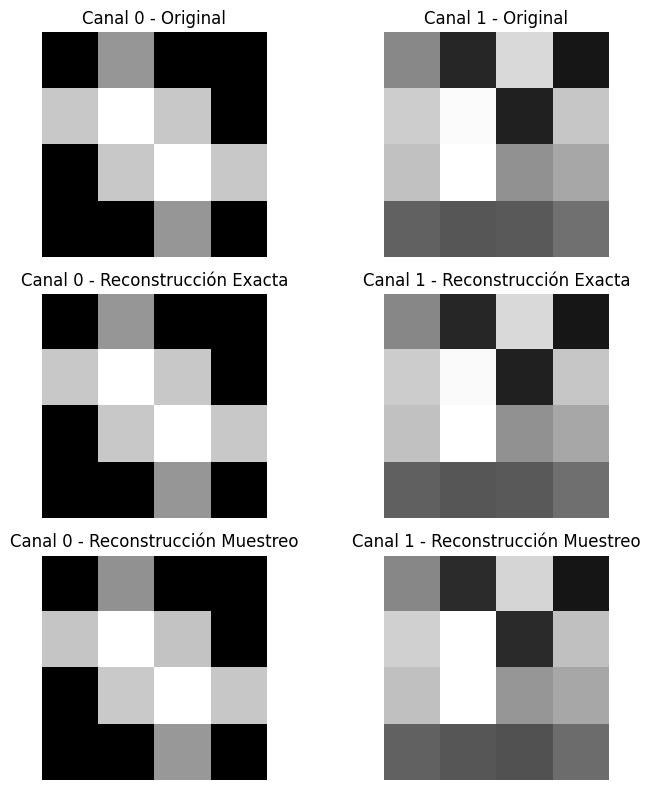

Canal 0:  MAE exacta=0.000 | MAE muestreo=1.062
Canal 1:  MAE exacta=0.375 | MAE muestreo=3.188


In [5]:
# Reconstrucción exacta vs muestreo

# 1) Estado exacto (vector de estado)
state = model.encode(*images)

# 2) Reconstrucción exacta (sin muestreo)
rec_exact = model.recover(state, shots=None)  # lista de imágenes por canal

# 3) Reconstrucción por muestreo (usando device_sampling de forma temporal)
_backup = model.device_str
model.device_str = device_sampling  # usar backend de muestreo para recover()
rec_samp = model.recover(state, shots=shots)  # lista de imágenes por canal
model.device_str = _backup  # restaurar

# Nota: para >1 qubit de color, recover invierte el orden interno (ver implementación).
#       Aquí mostramos los canales tal como salen de recover() con su índice.

# 4) Visualización comparativa por canal
nC = model.n_color_qubits
fig, axs = plt.subplots(3, nC, figsize=(4*nC, 8))
if nC == 1:
    axs = np.array([[axs[0]], [axs[1]], [axs[2]]])

for k in range(nC):
    # Original (si pasaste una sola imagen y se replicó, mostramos la entrada común)
    orig = images[k] if len(images) > 1 else images[0]
    axs[0, k].imshow(orig, cmap="gray", vmin=0, vmax=255)
    axs[0, k].set_title(f"Canal {k} - Original")
    axs[0, k].axis("off")

    axs[1, k].imshow(rec_exact[k], cmap="gray", vmin=0, vmax=255)
    axs[1, k].set_title(f"Canal {k} - Reconstrucción Exacta")
    axs[1, k].axis("off")

    axs[2, k].imshow(rec_samp[k], cmap="gray", vmin=0, vmax=255)
    axs[2, k].set_title(f"Canal {k} - Reconstrucción Muestreo")
    axs[2, k].axis("off")

plt.tight_layout()
plt.show()

# 5) Errores simples (MAE) por canal
def mae(a, b): return np.mean(np.abs(a.astype(np.float32) - b.astype(np.float32)))
for k in range(nC):
    orig = images[k] if len(images) > 1 else images[0]
    print(f"Canal {k}:  MAE exacta={mae(orig, rec_exact[k]):.3f} | MAE muestreo={mae(orig, rec_samp[k]):.3f}")


## Medidas de Correlación Cuántica

La **información mutua cuántica** es el parámetro que captura todo tipo de correlaciones dentro del sistema cuántico, desde las correlaciones clásicas hasta las correlaciones cuánticas. Basada en la **entropía de von Neumann**, conforma todo un grupo de cantidades que dan cuenta de la dinámica de la información en el sistema cuántico, en este caso el modelo FRQI.

In [6]:
# Métricas de información: entropías e información mutua

# 1) Entropías y correlaciones (del estado exacto)
stats = model.analyze_state(state)

# Imprime algunas claves relevantes ordenadas
keys_prefer = [
    "H_total", "H_position",
]
for k in range(model.n_color_qubits):
    keys_prefer += [f"H_color{k}", f"I(color{k}:position)", f"H_color{k}|position"]
if model.n_color_qubits >= 2:
    keys_prefer += ["H_colors_joint", "I(color0:color1)", "H_color0|color1", "H_color1|color0", "I3(position:color0:color1)"]

print("— Entropías y correlaciones (exacto) —")
for k in keys_prefer:
    if k in stats:
        print(f"{k:>24s} = {stats[k]:.6f}")

# 2) Información mutua clásica entre color y posición
#    a) Exacta (a partir de |ψ|^2)
mi_exact = model.mi_samples(*images, shots=None)
#    b) Estimada por muestreo (usando backend de muestreo)
mi_emp = model.mi_samples(*images, shots=shots, backend=device_sampling)

print("\n— Información mutua color ↔ posición —")
print(f"MI exacta       = {mi_exact:.6f} bits")
print(f"MI por muestreo = {mi_emp:.6f} bits (shots={shots})")

# 3) (Opcional) MI por bloques (coarse graining de la posición)
#    Por ejemplo, si image_size=8 → n_pos_qubits=6 → puedes elegir n_blocks=16 (4x4 bloques)
#    Descomenta para usar:
# mi_emp_blocks = model.mi_samples(*images, shots=shots, backend=device_sampling, n_blocks=16)
# print(f\"MI por muestreo (n_blocks=16) = {mi_emp_blocks:.6f} bits\")


— Entropías y correlaciones (exacto) —
                 H_total = 0.000000
              H_position = 1.585952
                H_color0 = 0.928084
      I(color0:position) = 1.831890
       H_color0|position = -0.903806
                H_color1 = 0.682147
      I(color1:position) = 1.340015
       H_color1|position = -0.657868
          H_colors_joint = 1.585952
        I(color0:color1) = 0.024278
         H_color0|color1 = 0.903806
         H_color1|color0 = 0.657868
I3(position:color0:color1) = 0.000000

— Información mutua color ↔ posición —
MI exacta       = 1.169577 bits
MI por muestreo = 1.147506 bits (shots=8192)


## Referencias Adicionales

1. Nielsen, M. A., & Chuang, I. L. (2010). *Quantum Computation and Quantum Information*. Cambridge University Press.

2. PennyLane Documentation: [Measurements](https://docs.pennylane.ai/en/stable/introduction/measurements.html)